In [41]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import kurtosis 
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import statsmodels.tools.tools as smt
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [42]:
model_data = pd.read_excel('integrated_data_sheet_final.xlsx')
model_data

,Year,FIPS,County,State,% DIABETIC,% OBESE,% INACTIVE
0,2018,1011,Bullock County,Alabama,9.4,18.7,17.0
1,2018,2068,Denali Borough,Alaska,6.8,18.9,16.2
2,2018,2105,Hoonah-Angoon Census Area,Alaska,7.3,19.4,15.0
3,2018,2195,Petersburg Census Area,Alaska,9.2,17.2,17.8
4,2018,2230,Skagway Municipality,Alaska,6.6,18.3,15.8
...,...,...,...,...,...,...,...
349,2018,51820,Waynesboro City,Virginia,8.6,19.5,16.6
350,2018,51830,Williamsburg City,Virginia,8.5,18.0,15.7
351,2018,51840,Winchester City,Virginia,6.9,19.4,16.1
352,2018,53055,San Juan County,Washington,4.5,19.3,11.9


# Multiple Linear Regression

## Model 1 : Considering Independent Variables as Obesity and Inactivity ; Dependent Variable as Diabetic

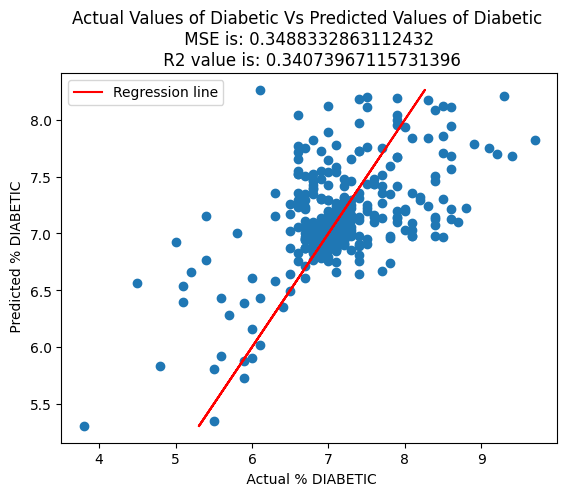

Coefficients : [0.23246992 0.11106297]
Intercept : 1.6535991518559499
MSE is: 0.3488332863112432
R2 value is: 0.34073967115731396


In [43]:
#independent variables : % OBESE and % INACTIVE ; dependent variable : % DIABETIC
X = model_data[["% INACTIVE", "% OBESE"]]
y = model_data["% DIABETIC"]

model_mul = LinearRegression() #model

model_mul.fit(X,y) #fit the model

y_pred = model_mul.predict(X) # make predictions

plt.scatter(y,y_pred)

plt.xlabel(" Actual % DIABETIC")
plt.ylabel(" Predicted % DIABETIC")

plt.plot(y_pred, y_pred, color = 'red', label = 'Regression line') # adding regression line
plt.legend()
plt.title("Actual Values of Diabetic Vs Predicted Values of Diabetic \n MSE is: 0.3488332863112432 \n R2 value is: 0.34073967115731396")
plt.show()

coef = model_mul.coef_ #coefficients
intercept = model_mul.intercept_  #intercepts
print("Coefficients :", coef)
print("Intercept :", intercept)

MSE = metrics.mean_squared_error(y, y_pred) # calculating MSE
print("MSE is:", MSE)
r2 = metrics.r2_score(y, y_pred) # calculating r2
print("R2 value is:", r2)


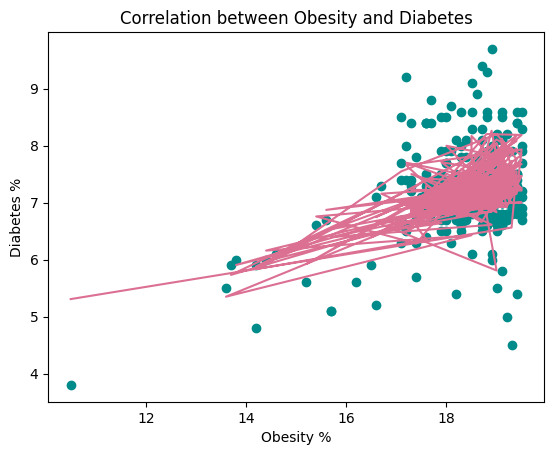

In [44]:
plt.scatter(model_data["% OBESE"], model_data["% DIABETIC"], color = 'darkcyan')
plt.plot(model_data["% OBESE"], y_pred, color='palevioletred')
plt.xlabel('Obesity %')
plt.ylabel('Diabetes %')
plt.title('Correlation between Obesity and Diabetes')
plt.show()

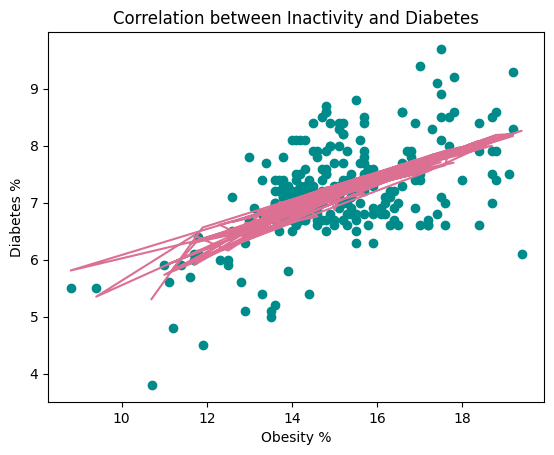

In [45]:
plt.scatter(model_data["% INACTIVE"], model_data["% DIABETIC"], color = 'darkcyan')
plt.plot(model_data["% INACTIVE"], y_pred, color='palevioletred')
plt.xlabel('Obesity %')
plt.ylabel('Diabetes %')
plt.title('Correlation between Inactivity and Diabetes')
plt.show()

## As the R2 value is not that satisfactory. We have to check whether data has any trend of heteroscedasticity or not by using the Breusch-Pagan test

In [46]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
resid = model.resid #residuals from the regression model
statistic, pvalue,_,_ = sm.stats.diagnostic.het_breuschpagan(resid, X)  # Perform the Breusch-Pagan test
print("breusch Pagan p-value", pvalue)

if pvalue > 0.05:
    print("There is no heteroscedasticity in the regression model.")
else:
    print("There is heteroscedasticity in the regression model.")

breusch Pagan p-value 3.555846910401976e-05
There is heteroscedasticity in the regression model.


### We can see there is a trend of heteroscedasticity So, we reject the null hypothesis and accept the alternate hypothesis.

### There are number of ways to handle heteroscedasticity, here We can use Weighted Least Squares(WLS) method 

In [47]:
model_data1 = model_data
import statsmodels.formula.api as sm

                            WLS Regression Results                            
Dep. Variable:               diabetes   R-squared:                       0.341
Model:                            WLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     90.71
Date:                Sun, 08 Oct 2023   Prob (F-statistic):           1.76e-32
Time:                        22:22:10   Log-Likelihood:                -315.89
No. Observations:                 354   AIC:                             637.8
Df Residuals:                     351   BIC:                             649.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6536      0.562      2.941      0.0

Text(0.5, 1.0, 'diabetic')

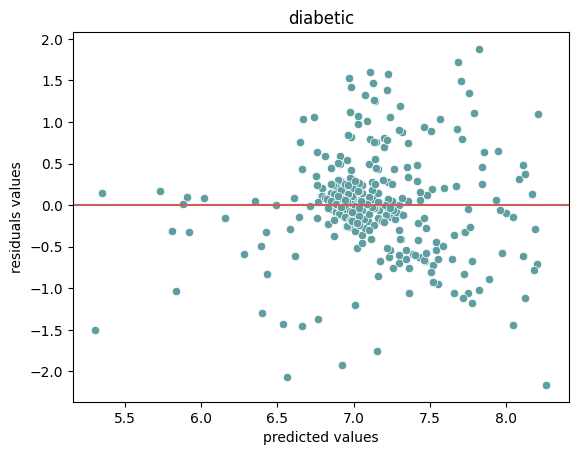

In [48]:
model_data1.columns = model_data.columns.str.replace('% DIABETIC', 'diabetes')
model_data1.columns = model_data.columns.str.replace('% OBESE', 'obesity')
model_data1.columns = model_data.columns.str.replace('% INACTIVE', 'inactivity')
X = model_data1[["inactivity", "obesity"]]
y = model_data1["diabetes"]

weights = 1 / model_data1["diabetes"].var()
model = sm.wls('diabetes ~ obesity+ inactivity', data=model_data1, weights=weights).fit() # Fit a WLS model to the data
print(model.summary())
conf_inter = model.conf_int() #confidence intervals
print(conf_inter)
model_data1["predicted values"] = model.predict(X)
model_data1["residuals values"] = model.resid
sns.scatterplot(data=model_data1, x="predicted values", y="residuals values", color = 'cadetblue')
plt.axhline(y=0, color ='indianred')
plt.title("diabetic")

## K-Fold Cross Validation

Cross-validation score: 0.444316315074101
training mse 0.326494724220722
test mse 0.444316315074101


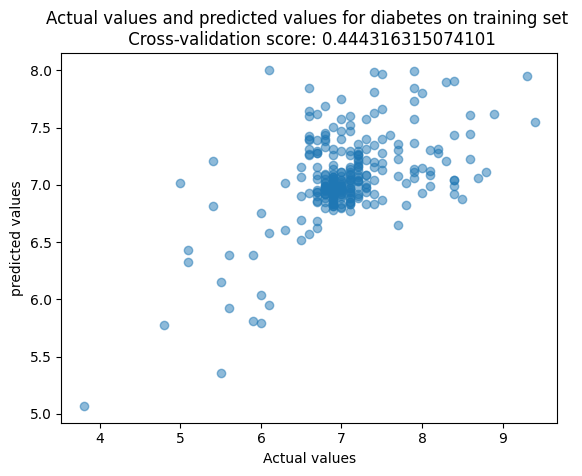

In [49]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_score = 0
for train_index, test_index in kf.split(model_data1):
    X_train, X_test, y_train, y_test = train_test_split(model_data1[["inactivity", "obesity"]], model_data1["diabetes"], test_size=0.25, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_tr = model.predict(X_train) #training set
    y_pred_te = model.predict(X_test)  #testing set
    mse_tr = np.mean((y_pred_tr - y_train)**2) # mse for training set
    mse_te = np.mean((y_pred_te - y_test)**2)  # mse for testing set
    cv_score += mse_te 
cv_score /= 5 #avg cv_score
print('Cross-validation score:', cv_score)
print('training mse',mse_tr)
print('test mse',mse_te)
plt.scatter(y_train,y_pred_tr, alpha=0.5)
plt.xlabel("Actual values")
plt.ylabel("predicted values")
plt.title("Actual values and predicted values for diabetes on training set \n Cross-validation score: 0.444316315074101")
plt.show()

